In [1]:
require './moromoro'

true

In [2]:
def angle_to_radian(angle)
  (angle.to_f / 360.0) * 2 * Math::PI
end

:angle_to_radian

In [3]:
# 右は次数mが正、左は次数mが負
# D: 0 → 区別なし, 1 → D1, 2 → D2
a_df = <<DATA.to_df
m, D, degree, minute, second
0, 0, 0, 0, 0
1, 0, 6, 47, 0
2, 0, 13, 39, 0
3, 2, 20, 42, 30
3, 1, 20, 44, 0
4, 2, 28, 8, 0
4, 1, 28, 10, 0
5, 2, 36, 7, 0
5, 1, 36, 9, 0
6, 2, 45, 1, 0
6, 1, 45, 4, 30
7, 2, 55, 37, 0
7, 1, 55, 41, 0
8, 2, 70, 25, 30
8, 1, 70, 34, 30
-1, 0, 6, 45, 30
-2, 0, 13, 38, 30
-3, 2, 20, 42, 30
-3, 1, 20, 43, 30
-4, 2, 28, 7, 30
-4, 1, 28, 9, 30
-5, 2, 36, 7, 0
-5, 1, 36, 9, 30
-6, 2, 45, 1, 0
-6, 1, 45, 5, 0
-7, 2, 55, 37, 30
-7, 1, 55, 42, 30
-8, 2, 70, 36, 0
-8, 1, 70, 47, 30
DATA
a_df.save_csv('csv/raw_data.csv')
a_radianed = a_df.map do |row|
  row.merge({ 'angle' => "#{row['degree'].to_i}°#{row['minute'].to_i}′#{row['second'].to_i}″", 'theta[rad]' => angle_to_radian(row['degree'] + row['minute']/60.0 + row['second']/3600.0) })
end.reset
nil

In [4]:
(0.5/60.to_f)/360 * 2 * Math::PI

0.0001454441043328608

In [5]:
ideal = { 1 => 589.592, 2 => 588.995 }
n = 2000 * 100
delta_theta = p (2/60.to_f)/360 * 2 * Math::PI #7.3 * 10**(-5)
a_with_calc = a_radianed.group_by { |row| [row['m'].abs, row['D']] }.map do |(m, d), v|
  two_theta_m = v.map { |row| row['theta[rad]'] }.inject(:+)
  theta_m = two_theta_m / 2
  lamb = Math.sin(two_theta_m/2)/(m * n)
  delta_lambda = (lamb.abs * delta_theta / Math.tan(theta_m) * 10**9).round(2)
  error = (ideal[d.to_i] || 0) - (lamb * 10**9)
  {
    'm' => m.to_i,
    'D' => d.to_i,
    'angle_left' => v.find { |row| row['m'] < 0.0 }&.fetch('angle') { nil } || v.first['angle'],
    'angle_right' => v.find { |row| row['m'] > 0.0 }&.fetch('angle') { nil } || v.first['angle'],
    '2_theta_m' => two_theta_m.round(4),
    'theta_m' => theta_m.round(4),
    'sin_theta_m' => Math.sin(theta_m).round(4),
    'lambda[nm]' => (lamb * 10**9),
    'delta_lambda[nm]' => delta_lambda,
    'ideal[nm]' => ideal[d.to_i],
    'in_error?' => error.abs - delta_lambda,
    'error' => error,
  }
end.to_df

0.0005817764173314432


m,D,angle_left,angle_right,2_theta_m,theta_m,sin_theta_m,lambda[nm],delta_lambda[nm],ideal[nm],in_error?,error
0,0,0°0′0″,0°0′0″,0.0,0.0,0.0,NaN,NaN,,NaN,NaN
1,0,6°45′30″,6°47′0″,0.2363,0.1182,0.1179,589.4923978029327,2.89,,586.6023978029327,-589.4923978029327
2,0,13°38′30″,13°39′0″,0.4763,0.2382,0.2359,589.7988769236579,1.41,,588.3888769236579,-589.7988769236579
3,2,20°42′30″,20°42′30″,0.7229,0.3614,0.3536,589.3514914321562,0.91,588.995,-0.55350856784381,-0.35649143215619006
3,1,20°43′30″,20°44′0″,0.7236,0.3618,0.354,589.9183163781055,0.91,589.592,-0.5836836218944973,-0.32631637810550274
4,2,28°7′30″,28°8′0″,0.9819,0.4909,0.4715,589.3260883795546,0.64,588.995,-0.3089116204454422,-0.33108837955455783
4,1,28°9′30″,28°10′0″,0.9831,0.4915,0.472,589.9673149210349,0.64,589.592,-0.264685078965058,-0.375314921034942
5,2,36°7′0″,36°7′0″,1.2607,0.6304,0.5894,589.4313671522699,0.47,588.995,-0.03363284773010489,-0.4363671522698951
5,1,36°9′30″,36°9′0″,1.262,0.631,0.59,589.959956813024,0.47,589.592,-0.1020431869760341,-0.3679568130239659
6,2,45°1′0″,45°1′0″,1.5714,0.7857,0.7073,589.4270335769214,0.34,588.995,0.09203357692141251,-0.43203357692141253


In [15]:
a_with_calc.map do |row|
  {
    'm' => row['m'],
    'D' => row['D'] == 0 ? '' : "$ D_#{row['D']} $",
    'angle(left)' => row['angle_left'],
    'angle(right)' => row['angle_right'],
    '\theta_m' => row['theta_m'],
    '\sin\theta_m' => row['sin_theta_m'],
    '\lambda[nm]' => row['lambda[nm]'].round(1),
    '\Delta\lambda_m[nm]' => row['delta_lambda[nm]'].round(1),
  }
end.to_df.save_csv('csv/data.csv')

"csv/data.csv"

line 325: warning: Skipping data file with no valid points
         line 341: warning: Skipping data file with no valid points
line 373: warning: Skipping data file with no valid points
         line 389: warning: Skipping data file with no valid points


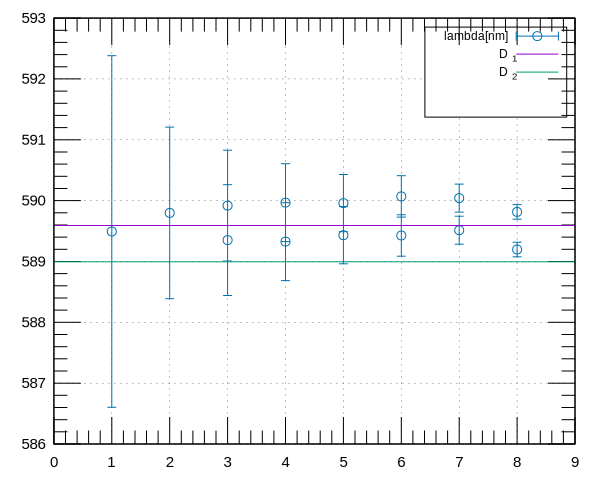

In [18]:
a_with_calc.plot(
  targets: [
    { function: '589.592', w: :lines, title: 'D_1', lt: 1 },
    { function: '588.995', w: :lines, title: 'D_2', lt: 2 },
    { x: 'm', y: 'lambda[nm]', yerror: 'delta_lambda[nm]', with: :yerrorbars, lt: 6 },
  ],
  options: {
    xrange: '[0:9]',
    key: 'right top box'
  },
  file: 'graph/a_with_calc.png'
)

In [8]:
a_with_calc.select { |row| row['D'] > 0 }.group_by { |row| row['D'] }.each do |d, rows|
  lm = rows.map { |row| row['lambda[nm]'] }.inject(:+) / rows.size.to_f
  puts "#{d}: #{lm.round(1)}, #{ideal[d]}, #{((ideal[d] - lm.round(1))/ideal[d] * 100).abs.round(2)}%"
end
nil

2: 589.4, 588.995, 0.07%
1: 590.0, 589.592, 0.07%


In [9]:
a_with_calc.select { |row| row['D'] > 0 }.group_by { |row| row['D'] }.each do |d, rows|
  with_weight = rows.map { |row| row.merge('weight' => 1/row['delta_lambda[nm]']**2) }
  lm = with_weight.map { |row| row['lambda[nm]']*row['weight'] }.inject(:+) / with_weight.map { |row| row['weight'] }.inject(:+)
  puts "#{d}: #{lm.round(1)}, #{ideal[d]}, #{((ideal[d] - lm.round(1))/ideal[d] * 100).abs.round(2)}%"
end
nil

2: 589.3, 588.995, 0.05%
1: 589.9, 589.592, 0.05%


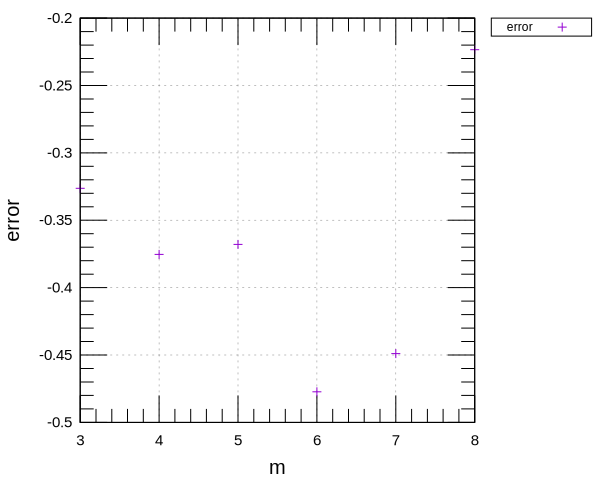

In [10]:
a_with_calc.select{ |row| row['D'] == 1 }.to_df.plot(
  targets: [ { x: 'm', y: 'error' } ]
)

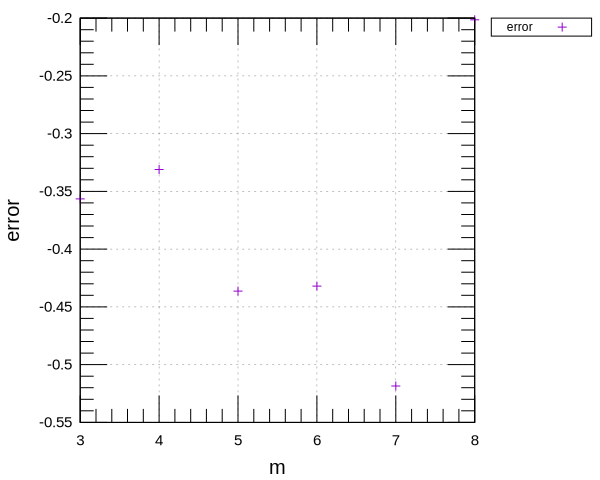

In [11]:
a_with_calc.select{ |row| row['D'] == 2 }.to_df.plot(
  targets: [ { x: 'm', y: 'error' } ]
)

In [12]:
a_with_calc_only_2 = a_with_calc.select { |row| row['D'] > 0 }.to_df

m,D,angle_left,angle_right,2_theta_m,theta_m,sin_theta_m,lambda[nm],delta_lambda[nm],ideal[nm],in_error?,error
3,2,20°42′30″,20°42′30″,0.7229,0.3614,0.3536,589.3514914321562,0.91,588.995,-0.55350856784381,-0.35649143215619006
3,1,20°43′30″,20°44′0″,0.7236,0.3618,0.354,589.9183163781055,0.91,589.592,-0.5836836218944973,-0.32631637810550274
4,2,28°7′30″,28°8′0″,0.9819,0.4909,0.4715,589.3260883795546,0.64,588.995,-0.3089116204454422,-0.33108837955455783
4,1,28°9′30″,28°10′0″,0.9831,0.4915,0.472,589.9673149210349,0.64,589.592,-0.264685078965058,-0.375314921034942
5,2,36°7′0″,36°7′0″,1.2607,0.6304,0.5894,589.4313671522699,0.47,588.995,-0.03363284773010489,-0.4363671522698951
5,1,36°9′30″,36°9′0″,1.262,0.631,0.59,589.959956813024,0.47,589.592,-0.1020431869760341,-0.3679568130239659
6,2,45°1′0″,45°1′0″,1.5714,0.7857,0.7073,589.4270335769214,0.34,588.995,0.09203357692141251,-0.43203357692141253
6,1,45°5′0″,45°4′30″,1.5736,0.7868,0.7081,590.0692739654949,0.34,589.592,0.13727396549487364,-0.47727396549487366
7,2,55°37′30″,55°37′0″,1.9415,0.9708,0.8253,589.5134796629421,0.23,588.995,0.2884796629421271,-0.5184796629421271
7,1,55°42′30″,55°41′0″,1.9442,0.9721,0.8261,590.0409368147592,0.23,589.592,0.21893681475923585,-0.44893681475923586


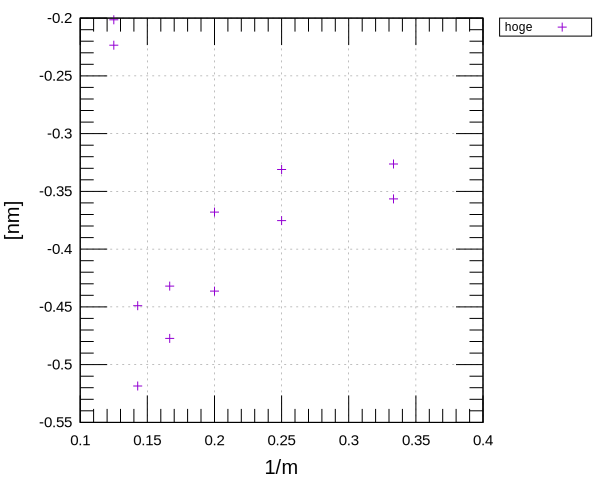

In [13]:
a_with_calc_only_2.map do |row|
  {
    '[nm]' => ideal[row['D']] - row['lambda[nm]'],
    '1/m' => 1.to_f/row['m']
  }
end.to_df.plot(
  targets: [{x: '1/m', y: '[nm]', title: 'hoge'}],
  options: {
    xrange: '[0.1:0.4]',
    yrange: '[-0.55:-0.2]'
  }
)

line 153: warning: Skipping data file with no valid points
         line 183: warning: Skipping data file with no valid points


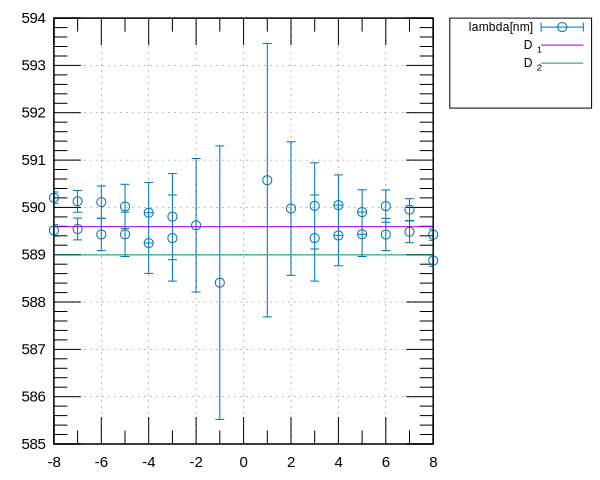

In [14]:
a_radianed.group_by { |row| [row['m'], row['D']] }.map do |(m, d), v|
  two_theta_m = v.map { |row| row['theta[rad]'] }.inject(:+)
  theta_m = two_theta_m
  lamb = Math.sin(theta_m)/(m.abs * n)
  delta_lambda = (lamb.abs * delta_theta / Math.tan(theta_m) * 10**9).round(2)
  error = (ideal[d.to_i] || 0) - (lamb * 10**9)
  {
    'm' => m.to_i,
    'D' => d.to_i,
    'angle_left' => v.find { |row| row['m'] < 0.0 }&.fetch('angle') { nil } || v.first['angle'],
    'angle_right' => v.find { |row| row['m'] > 0.0 }&.fetch('angle') { nil } || v.first['angle'],
    '2_theta_m' => two_theta_m.round(4),
    'theta_m' => theta_m.round(4),
    'sin_theta_m' => Math.sin(theta_m).round(4),
    'lambda[nm]' => (lamb * 10**9),
    'delta_lambda[nm]' => delta_lambda,
    'ideal[nm]' => ideal[d.to_i],
    'in_error?' => error.abs - delta_lambda,
    'error' => error,
  }
end.to_df.plot(
  targets: [
    { function: '589.592', w: :lines, title: 'D_1', lt: 1 },
    { function: '588.995', w: :lines, title: 'D_2', lt: 2 },
    { x: 'm', y: 'lambda[nm]', yerror: 'delta_lambda[nm]', with: :yerrorbars, lt: 6 },
  ],
)